In [8]:
from TuneClass import *
import TuneClass
import Executable
import Envelope
from dbreader import *
from Executable import Tune
from Executable import main
import imp
import dbreader
imp.reload(dbreader)
imp.reload(Executable)
imp.reload(TuneClass)
imp.reload(Envelope)
import matplotlib.pyplot as plt
import re

In [19]:
import fcwt
from pydub import AudioSegment
import scipy.io.wavfile as wav  

In [262]:
class Tune:
    def __init__(self, X=None, T=None, R=None, M=None, L=None, key=None, abc=""):
        self.X = X  # Reference number
        self.T = T  # Title
        self.R = R  # Rhythm type
        self.M = M  # Meter
        self.L = L  # Default note length
        self.K = key  # Key signature
        self.abc = abc  # Full ABC notation
        self.notes = []  # Placeholder for extracted notes

    def extract_notes(self):
        """ Extracts the note sequence from ABC notation. """
        self.notes = abc_to_notestring(self.abc)
        self.notes = keychanger(self,self.key)
        self.tones = notes_to_semitones2(self,universal_encoder)  # Update after ABC is fully set
        self.waveform = np.float32(constructor(self,'piano',.15))
    def __str__(self):
        return f"X: {self.X}, T: {self.T}, R: {self.R}, M: {self.M}, L: {self.L}, K: {self.K}, Notes: {self.notes[:50]}..."

    def play(self,duration = .125,instrument='piano'):
        waveform = constructor(self,instrument,duration)
        waveform = np.float32(waveform)
        sd.play(waveform,samplerate=8000)
        sd.wait()

# Read the file and parse entries
tunes = []
with open("reels.txt", "r", encoding="utf-8") as file:
    current_tune = None  # Holds the current tune being parsed

    for line in file:
        line = line.strip()  # Remove leading/trailing whitespace
        
        if not line:  # Empty line indicates a new tune might be starting
            if current_tune:  # If there's an active tune, store it
                tunes.append(current_tune)
            current_tune = None  # Reset for the next tune
            continue

        if line.startswith("X:"):  # Start of a new tune
            if current_tune:  # Store the previous tune before starting a new one
                tunes.append(current_tune)
            current_tune = Tune(X=line[2:].strip())  # Create new tune instance
        elif line.startswith("T:") and current_tune:
            current_tune.T = line[2:].strip()
        elif line.startswith("R:") and current_tune:
            current_tune.R = line[2:].strip()
        elif line.startswith("M:") and current_tune:
            current_tune.M = line[2:].strip()
        elif line.startswith("L:") and current_tune:
            current_tune.L = line[2:].strip()
        elif line.startswith("K:") and current_tune:
            current_tune.key = line[2:].strip()
        elif current_tune and not re.match(r"^[SCZ]:", line):  # All other lines are part of the ABC notation
            current_tune.abc += line + "\n"

    # Append the last parsed tune (if any)
    if current_tune:
        current_tune.extract_notes()
        tunes.append(current_tune)
for i in tunes:
    i.extract_notes()


In [ ]:
# image editing
import cv2
import numpy as np

def reduce_resolution(image, new_shape):
    # Compute magnitude and phase
    magnitude = np.abs(image)
    phase = np.angle(image)
    
    # Resize using OpenCV
    magnitude_resized = cv2.resize(magnitude, new_shape, interpolation=cv2.INTER_AREA)  # Best for downscaling
    phase_resized = cv2.resize(phase, new_shape, interpolation=cv2.INTER_LINEAR)  # Phase needs smooth interpolation
    
    # Reconstruct the complex image
    resized_image = magnitude_resized * np.exp(1j * phase_resized)
    
    return resized_image

def increase_contrast_complex(image, alpha=2.0, beta=0):
    """
    Increase the contrast of a complex image array.
    
    Parameters:
    - image: Complex numpy array (with real and imaginary parts)
    - alpha: Contrast control (1.0 means no change, >1.0 increases contrast)
    - beta: Brightness control (0 means no change)
    
    Returns:
    - contrasted_image: The complex image with enhanced contrast
    """
    # Separate magnitude and phase
    magnitude = np.abs(image)
    phase = np.angle(image)
    
    # Apply contrast enhancement to magnitude
    magnitude_contrasted = np.clip(alpha * magnitude + beta, 0, 1)
    
    # Reconstruct the complex image with the enhanced magnitude
    contrasted_image = magnitude_contrasted * np.exp(1j * phase)
    
    return contrasted_image

In [418]:
# transform, wavelet coherence, transform plot
import numpy as np
from pycwt import wct
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve1d,zoom
import scipy.io.wavfile as wav
from PIL import Image, ImageEnhance
# Compute the wavelet coherence
def gamma_correction_complex(image, gamma=.35,clip_point = .5):
    # Compute magnitude and phase    
    magnitude = np.abs(image)
    phase = np.angle(image)
    magnitude_max = np.max(magnitude)
    if magnitude_max > 0:
        magnitude = magnitude / magnitude_max  # Normalize to [0,1]
    magnitude = np.clip(magnitude*4,clip_point,1)
    # Apply gamma correction to the magnitude
    magnitude_corrected = np.power(magnitude, gamma)
    blur_strength = 2
    blur_kernel = np.ones(blur_strength) / blur_strength  # 1D blur kernel
    magnitude_corrected = convolve1d(magnitude_corrected, blur_kernel, axis=1, mode='reflect')

    # Reconstruct the complex image
    corrected_image = magnitude_corrected * np.exp(1j * phase)
    return corrected_image

def transform(signal1,frame_rate,clip_point,correction= True):
    highest = 5000
    lowest = 200
    nfreqs = 600
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,scaling='log')
    coeffs1 = reduce_resolution(coeffs1, (400,200))
    if correction:
        coeffs1 = gamma_correction_complex(coeffs1,clip_point = clip_point)
    return coeffs1,freqs

def transform_plot(signal,frame_rate,clip_point,correction = True):
    coeffs1,freqs = transform(signal,frame_rate,clip_point,correction)
    plt.figure(figsize=(10, 5))
    plt.imshow(np.abs(coeffs1), aspect='auto', extent=[0, len(signal)/frame_rate, freqs[0], freqs[-1]], cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Wavelet Transform Magnitude')
    plt.show()
    return coeffs1,freqs

def wavelet_coherence(coeffs1,coeffs2,frame_rate,freqs):

    # Compute coherence
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)
    
    # Smooth spectra and cross-spectrum
    def smooth(data, sigma=(2,2), mode='nearest'):
        return data
        #ensure only horizontal smoothing
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smoothed = smooth(S1)
    S2_smoothed = smooth(S2)
    S12_smoothed = smooth(np.abs(S12) ** 2)

    # Coherence calculation
    #coherence = S12_smoothed / (((S1_smoothed) **2) * ((S2_smoothed)**2))
    coherence = S12_smoothed / (np.sqrt(S1_smoothed) * np.sqrt(S2_smoothed))

    return coherence, freqs 




In [ ]:
def match_signal_length(signal1, signal2, pad_value=0):
    """
    Adjusts signal2 to match the length of signal1 by either padding or trimming.
    
    Parameters:
    - signal1 (numpy array): The reference signal.
    - signal2 (numpy array): The signal to adjust.
    - pad_value (int or float, optional): The value to use for padding. Default is 0.
    
    Returns:
    - numpy array: signal2, modified to match the length of signal1.
    """
    len1 = len(signal1)
    len2 = len(signal2)
    
    if len2 > len1:
        # Trim signal2 if it's longer
        return signal2[:len1]
    elif len2 < len1:
        # Pad signal2 if it's shorter
        padding = np.full((len1 - len2,), pad_value)  # Create padding array
        return np.concatenate((signal2, padding))
    else:
        # Already the same length
        return signal2


In [24]:
def coherence_signals(tune,recording,frame_rate,plot=True):
    
    audio_data1 = np.array(recording, dtype=np.float32)
    audio_data1 -= np.mean(audio_data1)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max1 = np.max(np.abs(audio_data1))
    if max1 > 0:
        data1 = audio_data1 / max1
    data2 = tune.waveform
    audio_data2 = np.array(data2, dtype=np.float32)
    audio_data2 -= np.mean(audio_data2)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max2 = np.max(np.abs(audio_data2))
    if max2 > 0:
        data2 = audio_data2 / max2
        
    data2 = match_signal_length(data1, data2)
    coeffs1,freqs = transform(data1,frame_rate)
    coeffs2,_ = transform(data2,frame_rate)
    coherence, freqs = wavelet_coherence(coeffs1,coeffs2, frame_rate,freqs)
    extent=[0, len(data1)/frame_rate, len(freqs),0]

    coherence = np.clip(coherence,.7,None)
    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    if plot:
        plt.figure(figsize=(10, 6))
        plt.imshow(coherence, aspect='auto', extent=extent,cmap = 'jet')
        plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])
        plt.xticks(np.linspace(0, len(data1)/frame_rate, 5))
        plt.colorbar(label='Coherence')
        plt.ylabel('Scale (Frequency)')
        plt.xlabel('Time (seconds)')
        plt.title(f'Wavelet Coherence: {tune.T}')
        plt.show()
    return coeffs1,coeffs2,freqs,coherence


In [354]:
frame_rate = 8000
def create_transforms(tunes):
    for i in tunes:
        audio_data1 = np.array(i.waveform, dtype=np.float32)
        audio_data1 -= np.mean(audio_data1)
        # 2. Divide by the maximum absolute value to scale between -1 and 1
        max1 = np.max(np.abs(audio_data1))
        if max1 > 0:
            data1 = audio_data1 / max1
        i.transform = transform(data1,frame_rate,clip_point = .3)

In [534]:
# coherence plot
from IPython.display import display
def coherence_plot(tune,recording_transform,frame_rate,plot=True): 
    # should be able to take in a tune object and a recording object and
    # efficiently compute the coherence between the two waveforms. without having 
    # to recompute the wavelet transform for the tune object
    coeffs1 = tune.transform[0]
    coeffs2 = recording_transform
    freqs = tune.transform[1]
    coherence, freqs = wavelet_coherence(coeffs1,coeffs2, frame_rate,freqs)
    extent=[0, len(tune.waveform)/frame_rate, len(freqs),0]

    coherence = np.where(coherence<.1,0,coherence)
    max1 = np.max(np.abs(coherence))
    min1 = np.min(np.abs(coherence))
    coherence = (coherence-min1) / (max1-min1)
    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    plt_obj = None
    if plot:
        plt.figure(figsize=(10, 6))
        plt.imshow(coherence, aspect='auto', extent=extent,cmap = 'jet')
        plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])
        plt.xticks(np.linspace(0, len(tune.waveform)/frame_rate, 5))
        plt.colorbar(label='Coherence')
        plt.ylabel('Scale (Frequency)')
        plt.xlabel('Time (seconds)')
        plt.title(f'Wavelet Coherence: {tune.T}')
        plt_obj = plt.gcf()
        plt.close()

        
    return coeffs1,coeffs2,freqs,coherence,plt_obj


In [240]:
def align_using_cross_correlation(ref_signal, target_signal, sr):
    """
    Aligns target_signal to ref_signal using cross-correlation.
    
    Parameters:
        ref_signal (numpy array): The reference audio signal.
        target_signal (numpy array): The misaligned audio signal.
        sr (int): Sample rate of the audio.
        
    Returns:
        numpy array: The aligned target signal.
    """
    # Compute cross-correlation
    corr = np.correlate(target_signal, ref_signal, mode="full")
    lag = np.argmax(corr) - len(ref_signal) + 1  # Find the best shift

    # Apply time shift (trim or pad)
    if lag > 0:
        aligned_target = target_signal[lag:]  # Cut off leading part
    else:
        aligned_target = np.pad(target_signal, (abs(lag), 0), mode="constant")  # Pad with zeros

    return aligned_target

In [ ]:
# m4a to reel, trim silence
AudioSegment.converter = "C:/Users/24261951/Documents/Projects/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe"                  
from pydub import utils, AudioSegment

def get_prober_name():
    return "C:/Users/24261951/Documents/Projects/ffmpeg-master-latest-win64-gpl/bin/ffprobe.exe"
utils.get_prober_name = get_prober_name

def trim_silence(signal, threshold):
    """
    Removes all values before the signal first exceeds the threshold.
    
    Parameters:
    signal (numpy array): The input signal
    threshold (float): The minimum amplitude to start keeping values
    
    Returns:
    numpy array: Trimmed signal starting from the first peak above the threshold
    """
    # Find the first index where the signal exceeds the threshold
    index = np.argmax(np.abs(signal) >= threshold)
    
    # Slice the signal from that index onwards
    return signal[index:] if np.abs(signal[index]) >= threshold else np.array([])


In [546]:
# m4a to reel, wav to reel
def m4a_to_reel(file):
    audio = AudioSegment.from_file(file,format='m4a')
    audio = audio.set_frame_rate(8000)
    if audio.channels == 2:
        samples = samples.reshape((-1, 2)).mean(axis=1)
    audio = np.frombuffer(audio.raw_data,np.int16)
    audio = (audio)/max(abs(audio))
    audio = trim_silence(audio,0.5) # begin when playing starts
    audio = match_signal_length(tunes[0].waveform,audio)
    #audio = align_using_cross_correlation(tunes[1].waveform,audio,8000)
    return audio

def wav_to_reel(file):
    audio = AudioSegment.from_file(file,format='wav')
    audio = audio.set_frame_rate(8000)
    if audio.channels == 2:
        samples = samples.reshape((-1, 2)).mean(axis=1)
    audio = np.frombuffer(audio.raw_data,np.int16)
    audio = (audio)/max(abs(audio))
    audio = trim_silence(audio,0.5) # begin when playing starts
    audio = match_signal_length(tunes[0].waveform,audio)
    #audio = align_using_cross_correlation(tunes[1].waveform,audio,8000)
    return audio

In [554]:
# subplots from png
from PIL import Image
import os
import matplotlib.pyplot as plt

def create_subplots_from_png(directory):
    # Get list of all .png files in the directory
    png_files = [f for f in os.listdir(directory) if f.endswith('.png')]
    
    # Determine the number of rows and columns for the subplots
    num_files = len(png_files)
    cols = 6  # Number of columns in the subplot grid
    rows = (num_files // cols) + (num_files % cols > 0)  # Calculate rows needed

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for ax, png_file in zip(axes, png_files):
        img = Image.open(os.path.join(directory, png_file))
        ax.imshow(img)
        ax.set_title(png_file[:-4])
        ax.axis('off')  # Hide the axes

    # Hide any remaining empty subplots
    for ax in axes[num_files:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [559]:
import os
import shutil
def workflow(recording):
    file = f'recordings/{recording}'
    if file[-3:] == ('m4a'):
        tune = m4a_to_reel(file)
    elif file[-3:] == ('wav'):
        tune = wav_to_reel(file)
    else:
        return "Unsupported file format"
    sums = {}
    frame_rate = 8000
    tform = transform(tune,frame_rate,clip_point = .1)
    shutil.rmtree(f'coherence_results/{recording}/')
    os.makedirs(f'coherence_results/{recording}/')
    # Calculate the required number of rows
    for n,i in enumerate(tunes):
        _,_,_,coh,plt_obj = coherence_plot(i,tform[0],frame_rate,plot=True)
        
        
        plt_obj.savefig(f'coherence_results/{recording}/{i.T}.png')

        sums[i.T] = np.where(coh<.5,0,coh).sum()
    create_subplots_from_png(f'coherence_results/{recording}/')
    keys = list(sums.keys())
    values = list(sums.values())
    # Plot a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(keys, values)
    plt.xlabel('Tune')
    plt.xticks(rotation=90,fontsize=8)
    plt.ylabel('Total Coherence')   
    plt.title(f'Summed Coherence: Synthetics VS Recording {recording}')
    plt.savefig(f'coherence_results/{recording}/_summed_coherence.png')
    plt.show()
    
    return sums


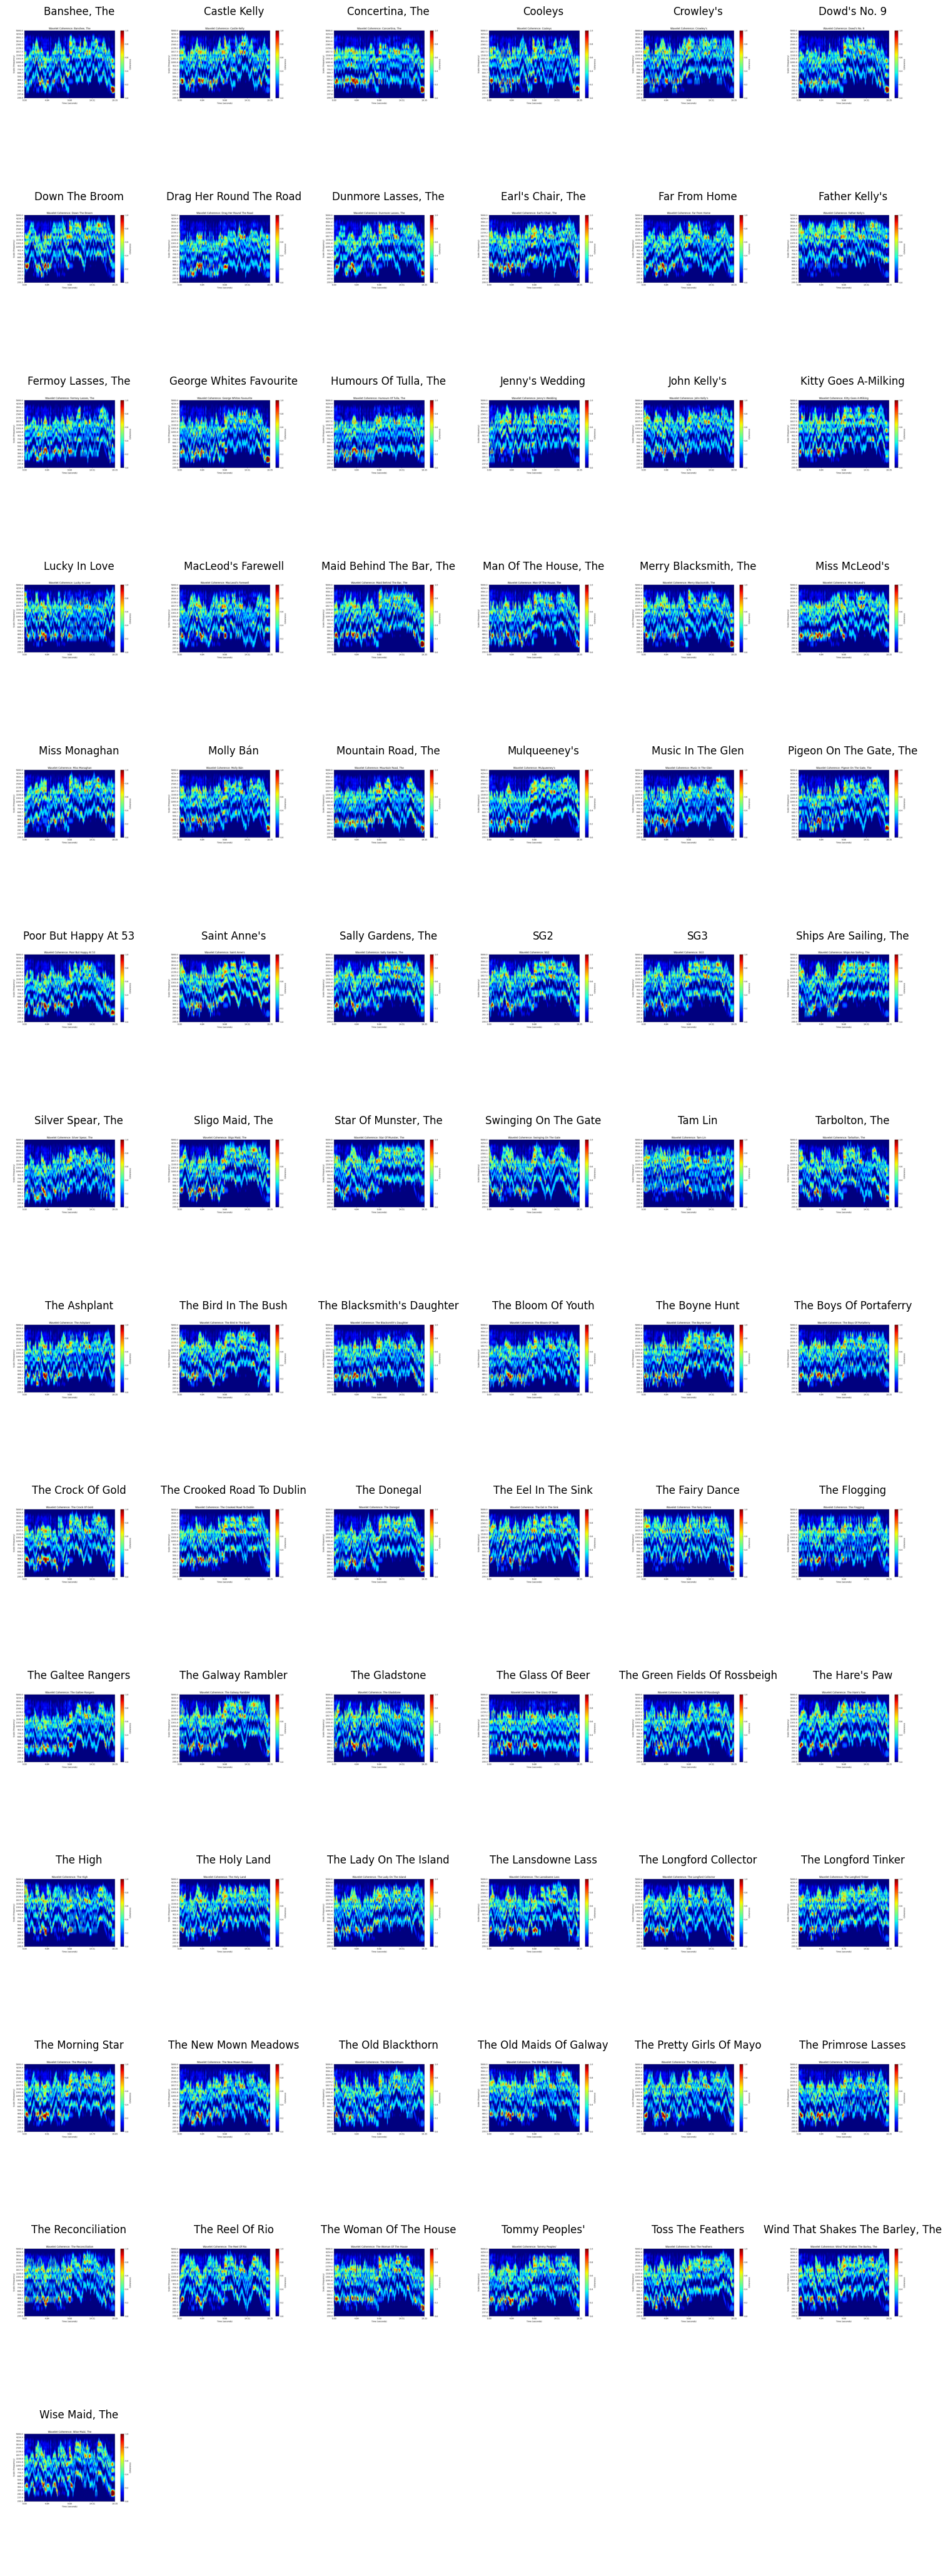

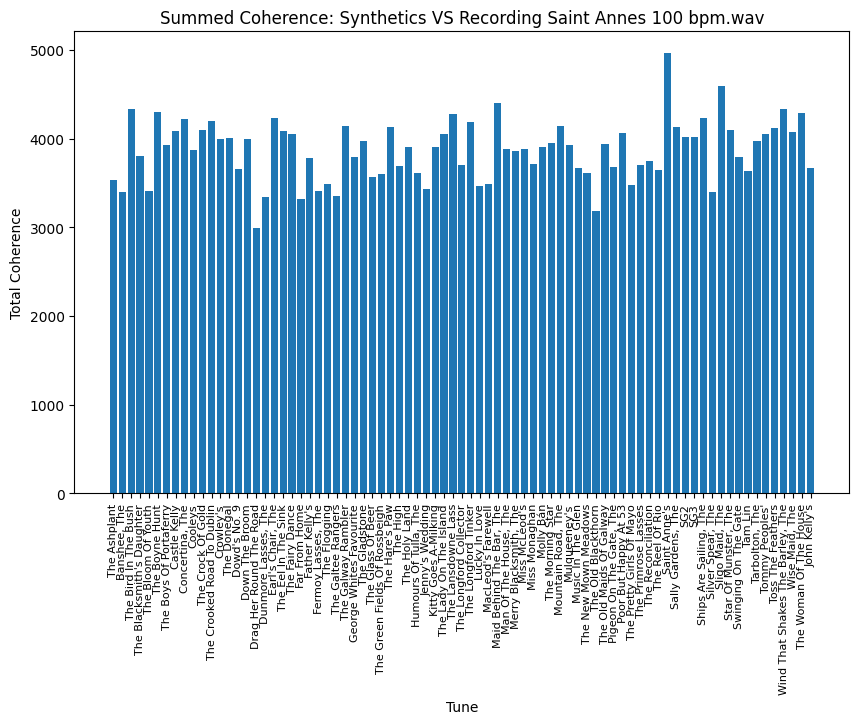

{'The Ashplant': 3534.1323,
 'Banshee, The': 3393.5808,
 'The Bird In The Bush': 4328.4966,
 "The Blacksmith's Daughter": 3804.6086,
 'The Bloom Of Youth': 3403.7297,
 'The Boyne Hunt': 4297.948,
 'The Boys Of Portaferry': 3924.643,
 'Castle Kelly': 4081.9058,
 'Concertina, The': 4222.428,
 'Cooleys': 3866.2815,
 'The Crock Of Gold': 4101.262,
 'The Crooked Road To Dublin': 4192.6484,
 "Crowley's": 3999.7527,
 'The Donegal': 4006.836,
 "Dowd's No. 9": 3651.157,
 'Down The Broom': 3996.7986,
 'Drag Her Round The Road': 2995.0803,
 'Dunmore Lasses, The': 3337.363,
 "Earl's Chair, The": 4234.4043,
 'The Eel In The Sink': 4087.955,
 'The Fairy Dance': 4052.0154,
 'Far From Home': 3314.644,
 "Father Kelly's": 3775.7922,
 'Fermoy Lasses, The': 3408.1682,
 'The Flogging': 3492.0198,
 'The Galtee Rangers': 3352.9717,
 'The Galway Rambler': 4138.6304,
 'George Whites Favourite': 3795.112,
 'The Gladstone': 3967.793,
 'The Glass Of Beer': 3571.3481,
 'The Green Fields Of Rossbeigh': 3595.0884,
 

In [560]:
workflow("Saint Annes 100 bpm.wav")